# はじめに

このノートではLightGBMのランキング学習を理解するために、末尾に記載の資料を参考にしながら、ランキング学習の基礎からLightGBMのランキング学習アルゴリズムについて理解を深める。ただ、ランキング学習に関して、体系的に学べる書籍やサイトを見つけることができず、様々な資料を参考にしているため、部分的に私の解釈が誤っている可能性がある。本来は下記の書籍を読むのが望ましいと思われるが、高価なため読めていない。

- [Learning to Rank for Information Retrieval | Liu, Tie-Yan ](https://www.amazon.co.jp/Learning-Rank-Information-Retrieval-Tie-Yan/dp/3642142664)

今回は下記の記事を参考にしながら、Kaggleのデータセットを利用してランキング学習を行うことで、LightGBMとランキング学習への理解を深める。

- [Learn to Implement a Learning-to-Rank Model for Product Recommendations: A Step-by-Step Guide | Towards Data Science](https://towardsdatascience.com/how-to-implement-learning-to-rank-model-using-python-569cd9c49b08)

## サンプルデータ

ここで使用するデータセットはAnime Recommendation LTR Dataset。下記よりダウンロードできる。

- [Anime Recommendation LTR Dataset](https://www.kaggle.com/datasets/ransakaravihara/anime-recommendation-ltr-dataset)

ここでの予測対象ランキングは、`relevance_scores`データセットに保存されている`relevance_score`。 

In [1]:
# load library
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import warnings
from sklearn import preprocessing,model_selection,metrics
from sklearn.preprocessing import MultiLabelBinarizer 
from sklearn.metrics import ndcg_score
import lightgbm as lgb
import shap



Zipファイルでダウンロードできるので、解凍して任意の場所に保存しておく。

In [2]:
# read dataset
anime_info = pd.read_csv('./AnimeRecommendationLTRDataset/anime_info.csv') 
relavence_scores = pd.read_csv('./AnimeRecommendationLTRDataset/relavence_scores.csv') 
user_info = pd.read_csv('./AnimeRecommendationLTRDataset/user_info.csv') 

`anime_info`テーブルは16,681×8のサイズで構成されており、各アニメの情報を記録されている。理由はよくわからないが`above_five_star_ratings`というカラムが2つ存在しており、値も全く同じっぽい。

In [3]:
anime_info

,anime_id,Genres,is_tv,year_aired,is_adult,above_five_star_users,above_five_star_ratings,above_five_star_ratio
0,1,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",1,1998.0,1,4012.0,4012.0,0.594018
1,5,"Action, Drama, Mystery, Sci-Fi, Space",0,2001.0,1,NaN,NaN,NaN
2,6,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",1,1998.0,0,NaN,NaN,NaN
3,7,"Action, Mystery, Police, Supernatural, Drama, ...",1,2002.0,0,NaN,NaN,NaN
4,8,"Adventure, Fantasy, Shounen, Supernatural",1,2004.0,0,76.0,76.0,0.481013
...,...,...,...,...,...,...,...,...
16676,48409,"Comedy, Parody",0,2021.0,0,NaN,NaN,NaN
16677,48411,"Sci-Fi, Slice of Life, Fantasy, Shounen",0,NaN,0,NaN,NaN,NaN
16678,48426,"Comedy, Demons, Supernatural, Shounen",0,NaN,0,NaN,NaN,NaN
16679,48438,"Slice of Life, Magic, Fantasy, Shounen",0,2021.0,0,NaN,NaN,NaN


`user_info`テーブルは15,163×6で構成されており、ユーザー情報が格納されている。

In [4]:
user_info

,user_id,review_count,avg_score,score_stddev,above_five_star_count,above_five_star_ratio
0,3,357,6.801120,2.475089,318.0,0.890756
1,6,545,4.089908,3.731472,285.0,0.522936
2,8,165,0.866667,2.448328,NaN,NaN
3,13,65,3.338462,4.191796,NaN,NaN
4,14,146,4.965753,3.844233,89.0,0.609589
...,...,...,...,...,...,...
15158,11765,1,0.000000,NaN,NaN,NaN
15159,16208,1,8.000000,NaN,1.0,1.000000
15160,15031,1,0.000000,NaN,NaN,NaN
15161,2680,1,0.000000,NaN,NaN,NaN


`relavence_scores`テーブルは4,878,999×4で構成されており、各アニメとユーザーの関連性スコアが保存されている。

In [5]:
relavence_scores

,anime_id,Name,user_id,relavence_score
0,1,Cowboy Bebop,3,1.000000
1,1,Cowboy Bebop,6,1.000000
2,1,Cowboy Bebop,8,0.230769
3,1,Cowboy Bebop,13,0.000000
4,1,Cowboy Bebop,14,0.500000
...,...,...,...,...
4878994,48456,SK∞: Crazy Rock Jam,11897,1.000000
4878995,48456,SK∞: Crazy Rock Jam,11977,0.000000
4878996,48456,SK∞: Crazy Rock Jam,14441,0.000000
4878997,48456,SK∞: Crazy Rock Jam,15597,1.000000


## 特徴量エンジニアリング

3つのデータセットを結合したデータを作成する必要がある。その過程で、特徴量エンジニアリングも合わせて行っておく。

`create_genre_flags`関数は、データからジャンル情報を取得し、指定された`popular_genres`のフラグを含む新しいデータを作成する。内部の動きとしては、データフレームから`Genres`カラムに欠損値が含まれるレコードを削除。次に、`Genres`カラムの値をカンマで分割し、余分な空白を取り除いて再連結する。その後、`MultiLabelBinarizer`を使用して、各アニメのジャンル情報をOne-Hotエンコーディングして、データフレームに変換する。

In [6]:
popular_genres = [
  'Comedy',
  'Action',
  'Fantasy',
  'Adventure',
  'Kids',
  'Drama',
  'Sci-Fi',
  'Music',
  'Shounen',
  'Slice of Life'
  ]

def create_genre_flags(df, popular_genres):
    df = df.dropna(subset=['Genres'])
    df['Genres'] = df['Genres'].apply(lambda x:",".join(s.strip() for s in x.split(",")))
    # use MultiLabelBinarizer to create a one-hot encoded dataframe of the genres
    mlb = MultiLabelBinarizer()
    genre_df = pd.DataFrame(mlb.fit_transform(df['Genres'].str.split(',')),
                            columns=mlb.classes_,
                            index=df.index)
    # create a new dataframe with the movie id and genre columns
    new_df = pd.concat([df['anime_id'], genre_df[popular_genres]], axis=1)
    new_df.columns = ['anime_id'] + popular_genres
    return new_df

前処理されたデータは下記の通り。

In [7]:
anime_genre_info_df = create_genre_flags(anime_info,popular_genres) 
anime_info_df_final = anime_info.merge(anime_genre_info_df,on='anime_id')
del anime_info_df_final['Genres']

anime_info_df_final.columns = [col if col=='anime_id' else f"ANIME_FEATURE {col}".upper() for col in anime_info_df_final.columns]
user_info.columns = [col if col=='user_id' else f"USER_FEATURE {col}".upper() for col in user_info.columns]

train_interim = relavence_scores.merge(anime_info_df_final)
train = train_interim.merge(user_info,how='inner')

train.head(10)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,anime_id,Name,user_id,relavence_score,ANIME_FEATURE IS_TV,ANIME_FEATURE YEAR_AIRED,ANIME_FEATURE IS_ADULT,ANIME_FEATURE ABOVE_FIVE_STAR_USERS,ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS,ANIME_FEATURE ABOVE_FIVE_STAR_RATIO,...,ANIME_FEATURE DRAMA,ANIME_FEATURE SCI-FI,ANIME_FEATURE MUSIC,ANIME_FEATURE SHOUNEN,ANIME_FEATURE SLICE OF LIFE,USER_FEATURE REVIEW_COUNT,USER_FEATURE AVG_SCORE,USER_FEATURE SCORE_STDDEV,USER_FEATURE ABOVE_FIVE_STAR_COUNT,USER_FEATURE ABOVE_FIVE_STAR_RATIO
0,1,Cowboy Bebop,3,1.0,1,1998.0,1,4012.0,4012.0,0.594018,...,1,1,0,0,0,357,6.80112,2.475089,318.0,0.890756
1,18,Initial D Fourth Stage,3,1.0,1,2004.0,0,613.0,613.0,0.656317,...,1,0,0,0,0,357,6.80112,2.475089,318.0,0.890756
2,25,Sunabouzu,3,0.0,1,2004.0,1,NaN,NaN,NaN,...,0,1,0,1,0,357,6.80112,2.475089,318.0,0.890756
3,30,Neon Genesis Evangelion,3,1.0,1,1995.0,0,4478.0,4478.0,0.655541,...,1,1,0,0,0,357,6.80112,2.475089,318.0,0.890756
4,43,Koukaku Kidoutai,3,1.0,0,1995.0,0,2353.0,2353.0,0.629144,...,0,1,0,0,0,357,6.80112,2.475089,318.0,0.890756
5,47,Akira,3,1.0,0,1988.0,0,2586.0,2586.0,0.685760,...,0,1,0,0,0,357,6.80112,2.475089,318.0,0.890756
6,57,Beck,3,0.0,1,2004.0,1,NaN,NaN,NaN,...,1,0,1,1,1,357,6.80112,2.475089,318.0,0.890756
7,60,Chrno Crusade,3,0.0,1,2003.0,1,NaN,NaN,NaN,...,0,0,0,1,0,357,6.80112,2.475089,318.0,0.890756
8,66,Azumanga Daioh,3,1.0,1,2002.0,0,1474.0,1474.0,0.523066,...,0,0,0,0,1,357,6.80112,2.475089,318.0,0.890756
9,71,Full Metal Panic!,3,1.0,1,2002.0,1,NaN,NaN,NaN,...,0,1,0,0,0,357,6.80112,2.475089,318.0,0.890756


データセットには合計480万のユーザーとアニメに対する関連性スコアと、15,000人のユーザー、16,000のアニメが存在している。簡単に可視化して各カラムの特徴を確認にする。

In [8]:
def create_histogram(data, xname, n_bins=100, background_color='#F3F3F3', title=None):
    
    import matplotlib as mpl
    mpl.rcParams['font.size'] = 15
    mpl.rcParams['font.family'] = 'sans-serif'
    # mpl.rcParams['font.weight'] = 'semibold'

    plt.figure(figsize=(10,8))
    plt.hist(data, bins=n_bins, color='#2596be', edgecolor='black')
    plt.xlabel(xname)
    plt.ylabel('Frequency')
    ax = plt.gca()
    ax.set_facecolor(background_color)
    plt.grid(True, which='both', color='lightgray', linewidth=0.5)
    plt.title(title.upper(),fontweight='semibold',fontfamily='sans-serif')
    plt.show()

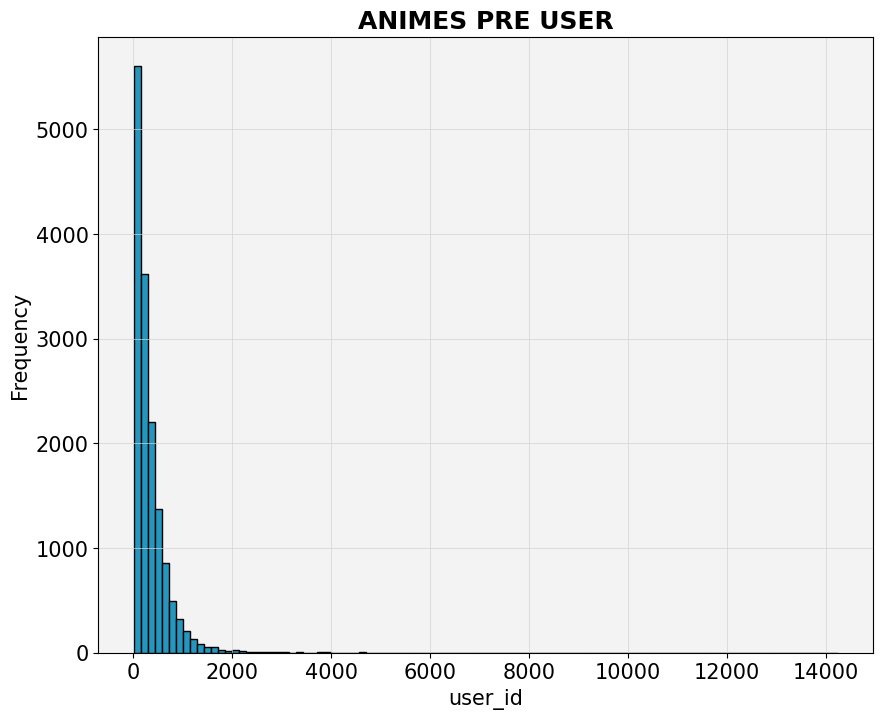

In [9]:
create_histogram(
  relavence_scores.groupby('user_id')['user_id'].agg('count'),
  xname='user_id', 
  n_bins=100, 
  title='Animes pre user'
  )


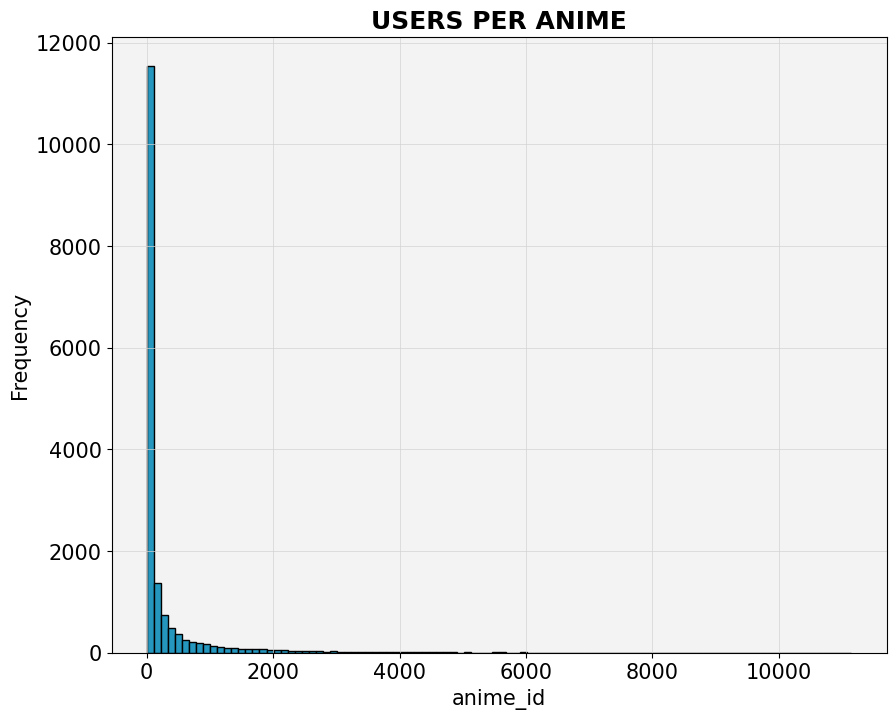

In [10]:
create_histogram(
  relavence_scores.groupby('anime_id')['anime_id'].agg('count'),
  xname='anime_id', 
  n_bins=100, 
  title='Users per anime'
  )


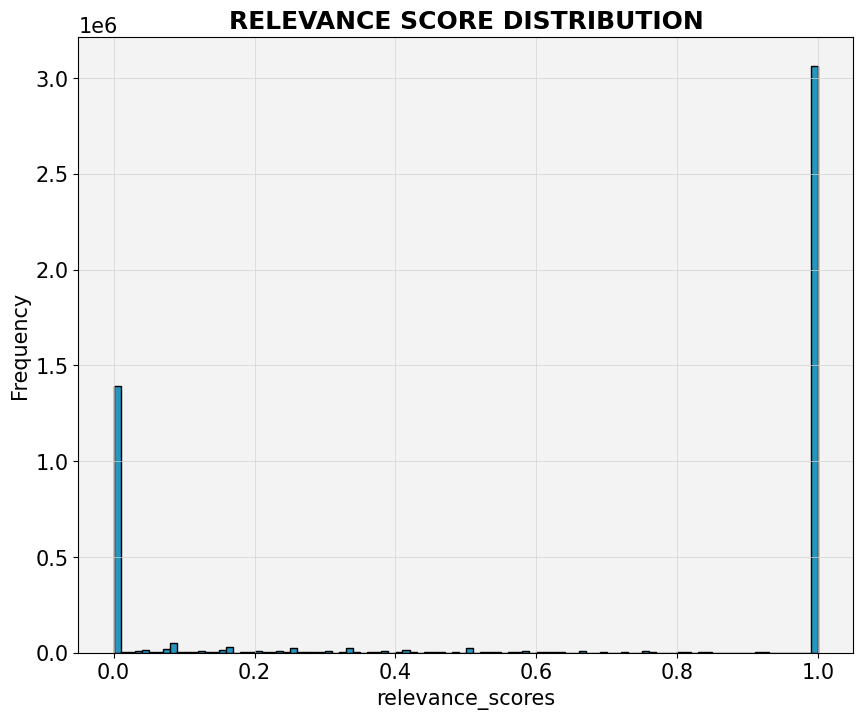

In [11]:
create_histogram(
  relavence_scores['relavence_score'],
  xname='relevance_scores',
  n_bins=100, 
  title='Relevance Score Distribution'
  )


## 学習データの作成

回帰や分類の機械学習を行うのであればこれでOKではあるが、ランキング学習では、クエリをまとめるグループパラメータが必要になる。グループパラメーターがあることで、クエリとドキュメントのペアごとにデータセットを分割できるようになり、モデルはグループ内のさまざまな特徴の相対的な重要性を学習できるようになる。そして、それがランキングの質を向上させることが期待できる。

グループパラメーターを作成するために、データセットを`user_id(query_id)`で並べ替えておく。また、LightGBMは、クエリごとに最大10,000行までしか処理できないという制限があるので、その制限を超えるユーザーは除外する。

In [12]:
na_counts = (train.isna().sum() * 100/len(train))
# カラムごとに行の50％が欠損値の場合、そのカラムを削除
train_processed = train.drop(na_counts[na_counts > 50].index,axis=1)
# ユーザーIDごとに並び替える
train_processed.sort_values(by='user_id',inplace=True)

# ユーザーごとの行数を数える
user_row_counts = train_processed['user_id'].value_counts()
# 10,000行を超えるユーザーのIDを取得する
exceeding_users = user_row_counts[user_row_counts > 10000].index.tolist()
# 10,000行を超えるユーザーを除外する
train_processed = train_processed[~train_processed['user_id'].isin(exceeding_users)]

# user_id 列をインデックスに設定し、inplace=True を指定することで、データフレームを直接変更。
train_processed.set_index("user_id",inplace=True)

train_processed.head(10)

,anime_id,Name,relavence_score,ANIME_FEATURE IS_TV,ANIME_FEATURE YEAR_AIRED,ANIME_FEATURE IS_ADULT,ANIME_FEATURE ABOVE_FIVE_STAR_USERS,ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS,ANIME_FEATURE ABOVE_FIVE_STAR_RATIO,ANIME_FEATURE COMEDY,...,ANIME_FEATURE DRAMA,ANIME_FEATURE SCI-FI,ANIME_FEATURE MUSIC,ANIME_FEATURE SHOUNEN,ANIME_FEATURE SLICE OF LIFE,USER_FEATURE REVIEW_COUNT,USER_FEATURE AVG_SCORE,USER_FEATURE SCORE_STDDEV,USER_FEATURE ABOVE_FIVE_STAR_COUNT,USER_FEATURE ABOVE_FIVE_STAR_RATIO
user_id,,,,,,,,,,,,,,,,,,,,,
0,19,Monster,0.000000,1,2004.0,0,NaN,NaN,NaN,0,...,1,0,0,0,0,71,4.732394,3.935036,NaN,NaN
0,1985,UFO Robo Grendizer,0.000000,1,1975.0,0,NaN,NaN,NaN,0,...,0,1,0,1,0,71,4.732394,3.935036,NaN,NaN
0,1894,Yu☆Gi☆Oh!: Hikari no Pyramid,1.000000,0,2004.0,0,525.0,525.0,0.716235,1,...,0,0,0,0,0,71,4.732394,3.935036,NaN,NaN
0,1887,Lucky☆Star,0.083333,1,2007.0,0,NaN,NaN,NaN,1,...,0,0,0,0,1,71,4.732394,3.935036,NaN,NaN
0,1829,Ged Senki,1.000000,0,2006.0,0,735.0,735.0,0.616611,0,...,0,0,0,0,0,71,4.732394,3.935036,NaN,NaN
0,1735,Naruto: Shippuuden,0.012000,1,2007.0,0,NaN,NaN,NaN,1,...,0,0,0,1,0,71,4.732394,3.935036,NaN,NaN
0,1726,Devil May Cry,0.166667,1,2007.0,1,NaN,NaN,NaN,0,...,0,0,0,0,0,71,4.732394,3.935036,NaN,NaN
0,2006,Yu☆Gi☆Oh! (Movie),0.000000,0,1999.0,0,NaN,NaN,NaN,1,...,0,0,0,1,0,71,4.732394,3.935036,NaN,NaN
0,1689,Byousoku 5 Centimeter,1.000000,0,2007.0,0,4050.0,4050.0,0.680558,0,...,1,0,0,0,1,71,4.732394,3.935036,NaN,NaN


欠損値が50%を超えるカラムを削除して、`user_id`に基づいて並べ替えられたデータセットを作成する。この処理を行わない場合、グループパラメータのグループとデータの整合性が取れなくなり、学習が適切に行われない。今回はテストデータとして、100,000レコードをテストデータとする。LightGBMはターゲットに整数を想定しているため、1～10の間で変換して整数化しておく。

In [13]:
features = [
  'ANIME_FEATURE IS_TV',
  'ANIME_FEATURE YEAR_AIRED', 
  'ANIME_FEATURE IS_ADULT',
  'ANIME_FEATURE ABOVE_FIVE_STAR_USERS',
  'ANIME_FEATURE ABOVE_FIVE_STAR_RATINGS',
  'ANIME_FEATURE ABOVE_FIVE_STAR_RATIO', 
  'ANIME_FEATURE COMEDY',
  'ANIME_FEATURE ACTION', 
  'ANIME_FEATURE FANTASY',
  'ANIME_FEATURE ADVENTURE', 
  'ANIME_FEATURE KIDS', 
  'ANIME_FEATURE DRAMA',
  'ANIME_FEATURE SCI-FI', 
  'ANIME_FEATURE MUSIC', 
  'ANIME_FEATURE SHOUNEN',
  'ANIME_FEATURE SLICE OF LIFE', 
  'USER_FEATURE REVIEW_COUNT',
  'USER_FEATURE AVG_SCORE', 
  'USER_FEATURE SCORE_STDDEV',
  'USER_FEATURE ABOVE_FIVE_STAR_COUNT',
  'USER_FEATURE ABOVE_FIVE_STAR_RATIO'
  ]
target = 'relavence_score'

test_size = int(1e5)
X,y = train_processed[features],train_processed[target].apply(lambda x:int(x * 10))
# test_idx_start = len(X)-test_size
# xtrain,xtest,ytrain,ytest = X.iloc[0:test_idx_start],X.iloc[test_idx_start:],y.iloc[0:test_idx_start],y.iloc[test_idx_start:]

この段階で必要なカラムだけに限定されているので、さらに学習、検証、テストの3つに分割していく。

In [14]:
# データの行数を取得
total_rows = X.shape[0]

# データを学習セット、検証セット、テストセットに分割する割合を計算
train_ratio = 0.6
valid_ratio = 0.2
test_ratio  = 0.2

# それぞれのセットのサイズを計算
train_size = int(total_rows * train_ratio)
val_size = int(total_rows * valid_ratio)

# データを分割
X_train = X.iloc[:train_size]
X_valid = X.iloc[train_size:train_size + val_size]
X_test  = X.iloc[train_size + val_size:]

# データを分割
y_train = y.iloc[:train_size]
y_valid = y.iloc[train_size:train_size + val_size]
y_test  = y.iloc[train_size + val_size:]

# 分割したデータのサイズを確認
print("Train data size:", X_train.shape)
print("Validation data size:", X_valid.shape)
print("Test data size:", X_test.shape)


Train data size: (2918623, 21)
Validation data size: (972874, 21)
Test data size: (972875, 21)


次にユーザーごとのアニメの数を計算する。`qids_*`という名前にしているが、別に他の名前でも問題ない。

In [15]:
# データセットのユーザーごとのグループサイズを取得
# array([ 71, 126, 484, ..., 102,   9, 130])
qids_train = X_train.groupby(level='user_id').size().to_numpy()
qids_val = X_valid.groupby(level='user_id').size().to_numpy()
qids_test = X_test.groupby(level='user_id').size().to_numpy()

train = lgb.Dataset(X_train, y_train, group=qids_train)
valid = lgb.Dataset(X_valid, y_valid, reference=train, group=qids_val)

In [16]:
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'lambdarank_truncation_level': 10,
    'ndcg_eval_at': [3, 5, 10],
    'n_estimators': 1000,
    'boosting_type': 'gbdt',
    'random_state': 1,
    'verbose': -1
}
# この数字を1にすると学習時のスコア推移がコマンドライン表示される
# verbose_eval = 0
model = lgb.train(
    params, 
    train_set=train, 
    valid_sets=[valid], 
    valid_names=['valid'],
    num_boost_round=10000,  
    # early_stopping用コールバック関数
    callbacks=[
        lgb.early_stopping(stopping_rounds=100, verbose=True), 
        lgb.log_evaluation(5),
        #lgb.log_evaluation(verbose_eval)
        ]
    )

Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 100 rounds
[5]	valid's ndcg@3: 0.886267	valid's ndcg@5: 0.87979	valid's ndcg@10: 0.872445
[10]	valid's ndcg@3: 0.889969	valid's ndcg@5: 0.887294	valid's ndcg@10: 0.877791
[15]	valid's ndcg@3: 0.89271	valid's ndcg@5: 0.888959	valid's ndcg@10: 0.88099
[20]	valid's ndcg@3: 0.894921	valid's ndcg@5: 0.891801	valid's ndcg@10: 0.883573
[25]	valid's ndcg@3: 0.896044	valid's ndcg@5: 0.893891	valid's ndcg@10: 0.884481
[30]	valid's ndcg@3: 0.896552	valid's ndcg@5: 0.894192	valid's ndcg@10: 0.885465
[35]	valid's ndcg@3: 0.897856	valid's ndcg@5: 0.89518	valid's ndcg@10: 0.88635
[40]	valid's ndcg@3: 0.898596	valid's ndcg@5: 0.895548	valid's ndcg@10: 0.887306
[45]	valid's ndcg@3: 0.900326	valid's ndcg@5: 0.896853	valid's ndcg@10: 0.887989
[50]	valid's ndcg@3: 0.900612	valid's ndcg@5: 0.897229	valid's ndcg@10: 0.88772
[55]	valid's ndcg@3: 0.900789	valid's ndcg@5: 0.898055	valid's ndcg@10: 0.888287
[60]	valid's ndcg@3: 0.902712	valid's ndcg@5: 0.899632

学習が終わったので、予測値を計算し、nDCG@10を計算する。LightGBMのLambdaRankはPointwiseアプローチを使用して予測を生成するため、グループなどの追加パラメータを提供する必要がない。

- [Prediction for the Learn-to-Rank Application · Issue #3326 · microsoft/LightGBM · GitHub](https://github.com/microsoft/LightGBM/issues/3326)

> it is listwise, as all pairs in one list are used in training. And then, based on the scores of all pairs, the pointwise score is aggregated. In short, the lambdarank will calculate the score listwise, then reduce it pointwise. and the tree is learned to aggregated pointwise score. Therefore, it does not need to use listwise in prediction.

`pred`はランキングモデルのスコアを表しており、スコアが大きいほど高い順位にあるアイテムだということを表す。

In [17]:
pred = model.predict(X_test, num_iteration=model.best_iteration)
# 予測値にクエリ ID とランキングと正解を付与する
pred_df = pd.DataFrame({
    'user_id': X_test.index,
    'pred': pred,
    'true': y_test,
}).reset_index(drop=True)
pred_df[pred_df['user_id'] == 13223]

,user_id,pred,true
0,13223,-3.287991,0
1,13223,-3.719702,0
2,13223,-1.057260,10
3,13223,-1.334023,10
4,13223,-2.958331,10
...,...,...,...
303,13223,1.062320,10
304,13223,-2.647647,10
305,13223,-2.752244,10
306,13223,-3.320797,10


In [18]:
# user_idが1行のものを除外してNDCGを計算する
pred_df\
  .groupby('user_id')\
  .filter(lambda x: len(x) > 1)\
  .groupby('user_id')\
  .apply(lambda d: ndcg_score([d['true']], [d['pred']], k=10))\
  .mean()


0.8902091576140867

特定の顧客についていくつかの予測を立てたいが、予測された関連性スコアに従ってランク付けを行いたい。そのため、候補のアニメを生成するために、特定のユーザーが見てないアニメを選択する方法をここでは使用する。見てないアニメから N 個のランダムなサブセットを選択し、ユーザーと選択したN個のアニメサブセットに基づいて特徴を生成する。最後に、生成された特徴ベクトルを使用して関連性スコアを取得し、関連性スコアに基づいてアニメを並べ替える。他にも、ユーザーの好みのN個のジャンルを選択し、そのジャンルごとに、最も評価の高いM個のアニメを選択するような方法も考えられる。

In [19]:
user_2_anime_df = relavence_scores.groupby('user_id').agg({'anime_id':lambda x:list(set(x))})
user_2_anime_map = dict(zip(user_2_anime_df.index,user_2_anime_df['anime_id']))

#create candidate pool, this will be a all the animes in the database
candidate_pool = anime_info_df_final['anime_id'].unique().tolist()
  
#anime_id to it's name mapping
anime_id_2_name = relavence_scores.drop_duplicates(subset=['anime_id','Name'])[['anime_id','Name']]
anime_id_2_name_map = dict(zip(anime_id_2_name['anime_id'],anime_id_2_name['Name']))


In [20]:

def candidate_generation(user_id:int,candidate_pool:list,user_2_anime_map:dict,N:int):
    """
    Note: this a totally random generation, only for demo purpose
    Generates a list of N anime candidates for a given user based on their previously liked animes.
    
    Parameters:
        user_id (int): The user's ID.
        candidate_pool (list): A list of all possible anime candidates.
        user_2_anime_map (dict): A dictionary that maps users to their liked animes.
        N (int): The number of anime candidates to generate.
    
    Returns:
        already_interacted (list): List of animes which user already liked
        candidates (list): A list of N anime candidates for the user.
    """
    
    #get the already liked animes
    already_interacted = user_2_anime_map[user_id]

    #candidates will be rest of animes which are not exposed to user
    np.random.seed(1)
    candidates = list(set(candidate_pool) - set(already_interacted))
    
    return already_interacted,np.random.choice(candidates,size=N)


`generate_predictions`関数がやっていることは下記の通り。

1. `candidate_generation`関数を使用して、指定されたユーザーが既に好きなアニメと、候補となるアニメのリストを取得。推薦候補の選定が行われる。
2. 推薦候補となるアニメのリストを`DataFrame`に変換し、特徴量として使用するための準備を行う。候補のアニメに関する情報が含まれる。
3. ユーザーIDを特徴量として追加し、ユーザーに関する情報も特徴量に結合。これにより、候補のアニメとユーザーの情報が統合される。
4. 既に好きなアニメの数が候補のアニメの数より少ない場合、不足分を`-1`で埋めて拡張。これにより、特徴量の数を一致させる。
5. 推薦の対象となるアニメの`DataFrame`を作成し、そこにアニメの名前とランキングスコアを追加。ランキングスコアは、与えられた特徴量に基づいて`ranker`によって予測。
6. ランキングスコアで`DataFrame`をソートし、上位N個の推薦を選択。また、既に好きなアニメのリストも結果に追加。
7. 最終的な推薦結果を`DataFrame`として返す。

In [21]:
def generate_predictions(user_id,user_2_anime_map,candidate_pool,feature_columns,anime_id_2_name_map,ranker,N=100):
    """
    Generates predictions for anime recommendations for a given user.
    
    Parameters:
        user_id (int): The user's ID.
        user_2_anime_map (dict): A dictionary that maps users to their liked animes.
        candidate_pool (list): A list of all possible anime candidates.
        feature_columns (list): A list of feature columns to use for generating predictions.
        anime_id_2_name_map (dict): A dictionary that maps anime IDs to their names.
        ranker (object): A trained model object that is used to generate predictions.
        N (int): The number of anime predictions to generate.
        
    Returns:
        predictions (DataFrame): A dataframe containing the top N anime recommendations for the user.
    """
    already_liked,candidates = candidate_generation(user_id,candidate_pool,user_2_anime_map,N=10000)
    
    # Create dataframe for candidates
    candidates_df = pd.DataFrame(data=pd.Series(candidates,name='anime_id'))
    
    # Merge with feature dataframe
    features = anime_info_df_final.merge(candidates_df)
    
    # Add user id as a feature
    features['user_id'] = user_id
    
    # Merge with user information
    features = features.merge(user_info)
    
    # If number of already liked animes is less than number of candidates
    # Extend the already liked list with -1
    already_liked = list(already_liked)
    if len(already_liked) < len(candidates):
        append_list = np.full(fill_value=-1,shape=(len(candidates)-len(already_liked)))
        already_liked.extend(list(append_list))
    
    # Create dataframe for predictions
    predictions = pd.DataFrame(index=candidates)
    # Add anime names
    predictions['name'] = np.array([anime_id_2_name_map.get(id_) for id_ in candidates])
    # Generate predictions
    predictions['score'] = ranker.predict(features[feature_columns])
    predictions = predictions.sort_values(by='score',ascending=False).head(N)
    
    predictions[f'already_liked - sample[{N}]'] = [anime_id_2_name_map.get(id_) for id_ in already_liked[0:len(predictions)]]
    return predictions

ここでは`user_id = 13233`に対して、実際に使用してみる。

In [22]:
generate_predictions(
  user_id = 13223,
  user_2_anime_map = user_2_anime_map,
  candidate_pool = candidate_pool,
  feature_columns = features,
  anime_id_2_name_map = anime_id_2_name_map,
  ranker = model,
  N = 10
  )


,name,score,already_liked - sample[10]
1396,Future GPX Cyber Formula: Early Days Renewal,7.536704,Cowboy Bebop
38891,Sora no Method: Mou Hitotsu no Negai,7.536704,Cowboy Bebop: Tengoku no Tobira
8707,Wakusei Robo Danguard Ace tai Konchuu Robot Gu...,7.536704,Trigun
3406,iDOLM@STER Xenoglossia Specials,7.536704,Kiseijuu: Sei no Kakuritsu
21925,Chichiiro Toiki,7.369285,Yamada-kun to 7-nin no Majo (TV)
35204,The King of Fighters: Destiny,7.369285,Btooom!
6041,Honoo no Haramase Doukyuusei,7.369285,Trigun: Badlands Rumble
34935,Yowai Robot to 10 no Story Project,7.369285,Tengen Toppa Gurren Lagann Movie 1: Gurren-hen
9303,Noel no Fushigi na Bouken,7.369285,Tsuki ga Kirei
7113,30th Gundam Perfect Mission,7.152514,Little Witch Academia


shape を使用してモデルの予測を説明することもできる。

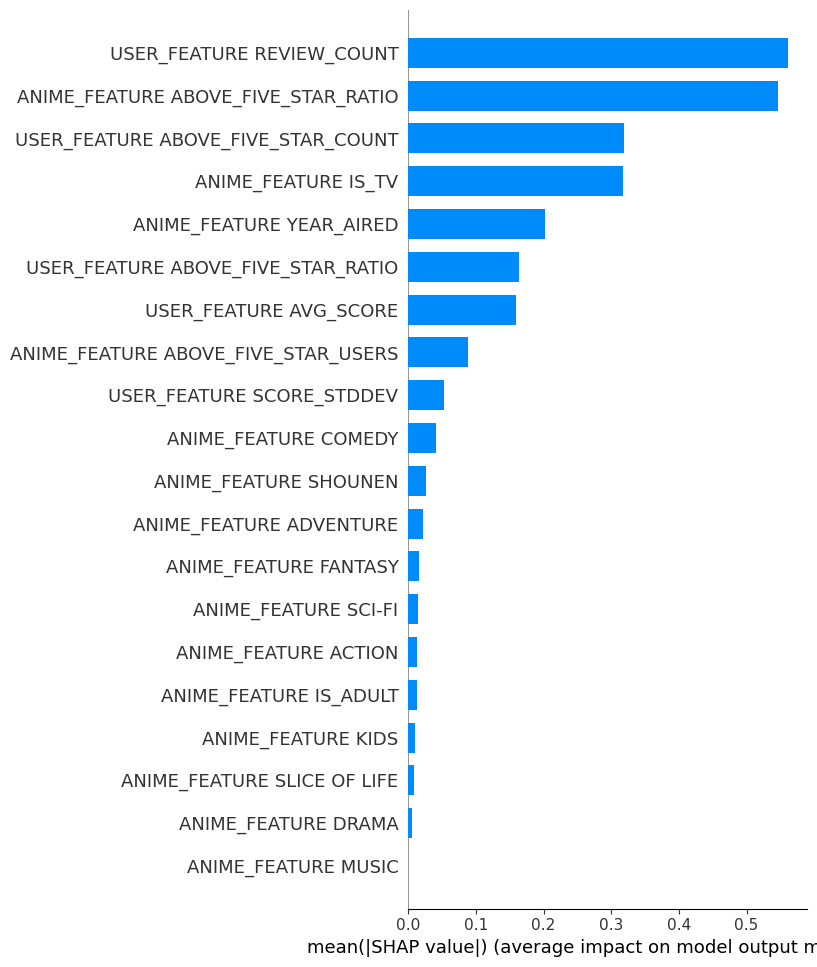

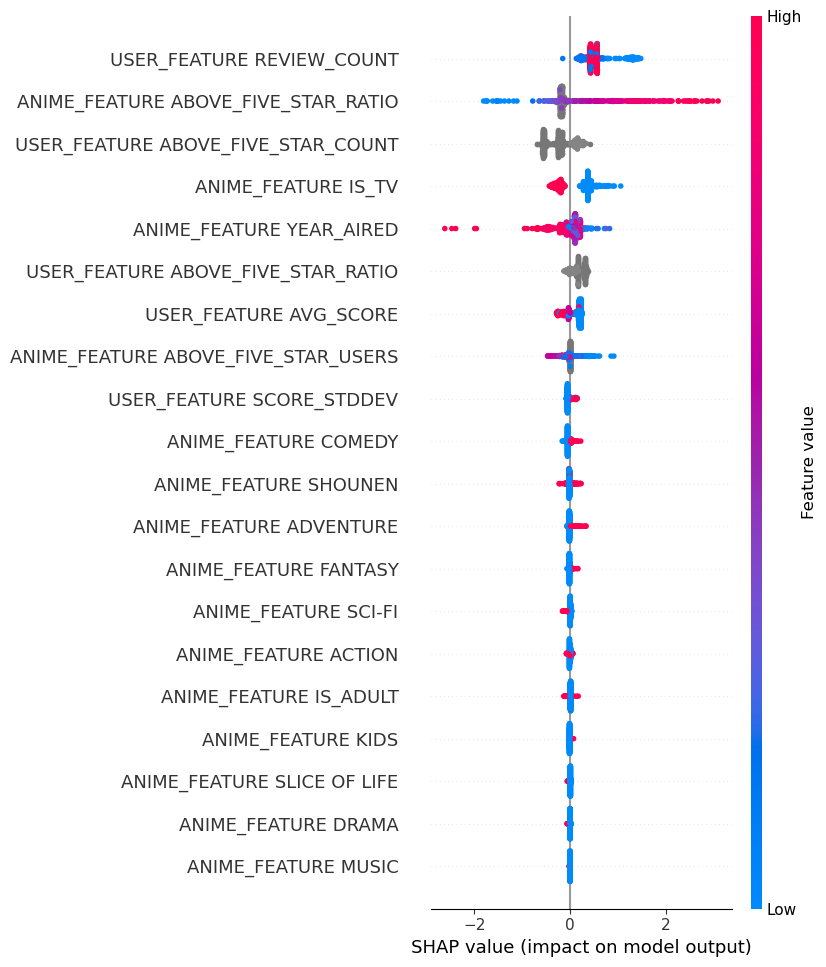

In [29]:

def generate_shap_plots(ranker, X_train, feature_names, N=3, font_size=8):
    """
    Generates SHAP plots for a pre-trained LightGBM model.
    
    Parameters:
        ranker (lightgbm.Booster): A trained LightGBM model
        X_train (np.ndarray): The training data used to fit the model
        feature_names (List): list of feature names
        N (int): The number of plots to generate
        font_size (int): The font size for the plot
    
    Returns:
        None
    """
    
    explainer = shap.Explainer(ranker, X_train, feature_names=feature_names)
    shap_values = explainer(X_train.iloc[:N])
    
    # Plot the summary plot
    shap.summary_plot(shap_values, feature_names=feature_names, plot_type='bar')
    shap.summary_plot(shap_values, feature_names=feature_names, plot_type='dot')
    
    plt.show()

generate_shap_plots(model, X_train, features, N=500, font_size=0.5)

## モデルの学習



## 参考資料

- [Anime Recommendation LTR Dataset](https://www.kaggle.com/datasets/ransakaravihara/anime-recommendation-ltr-dataset)
- [lightgbm.LGBMRanker — LightGBM 4.0.0 ドキュメント](https://lightgbm.readthedocs.io/en/stable/pythonapi/lightgbm.LGBMRanker.html)
- [Learn to Implement a Learning-to-Rank Model for Product Recommendations: A Step-by-Step Guide | Towards Data Science](https://towardsdatascience.com/how-to-implement-learning-to-rank-model-using-python-569cd9c49b08)
- [GitHub - Ransaka/LTR-with-LIghtGBM: The step-by-step guide on how to implement the lambdarank algorithm using Python and LightGBM](https://github.com/Ransaka/LTR-with-LIghtGBM)